In [1]:
import pickle

# Load meta dict

with open('../../PNC/AllSubjectsMeta.bin', 'rb') as f:
    meta = pickle.load(f)
    
# Load rest subject ids and splits

with open('../../Work/Abstract/PaperBin/AllThreeSplit.bin', 'rb') as f:
    splits = pickle.load(f)
    subids = splits['allThreeYesWrat']
    groups = splits['groups']
    
print(len(subids))

593


In [2]:
import numpy as np

subidsNp = np.array(subids)

# Load timeseries

def loadSeries(prefix, para, idx):
    with open('{:}/{:}_fmri_power264/timeseries/{:}.bin'.format(prefix, para, idx), 'rb') as f:
        return pickle.load(f)

rest_ts = [loadSeries('../../PNC', 'rest', meta[subid]['rest']) for subid in subidsNp]
nback_ts = [loadSeries('../../PNC', 'nback', meta[subid]['nback']) for subid in subidsNp]
emoid_ts = [loadSeries('../../PNC', 'emoid', meta[subid]['emoid']) for subid in subidsNp]

print('Loading complete')

Loading complete


In [3]:
import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(rest_ts)
normalizeSubjects(nback_ts)
normalizeSubjects(emoid_ts)

print('Complete')

Complete


In [4]:
# Calculate pearson matrices

rest_p = np.stack([np.corrcoef(sub) for sub in rest_ts])
nback_p = np.stack([np.corrcoef(sub) for sub in nback_ts])
emoid_p = np.stack([np.corrcoef(sub) for sub in emoid_ts])

print(rest_p.shape)
print('Complete')

(593, 264, 264)
Complete


In [5]:
# Create feature vectors (right now just ages, maleness, and femaless)

males = 0
females = 0

X_all = []
for subid in subidsNp:
    subj = meta[subid]
    maleness = 1 if subj['meta']['Gender'] == 'M' else 0
    femaleness = 1 if maleness == 0 else 0
    feat = np.array([subj['meta']['AgeInMonths'], maleness, femaleness])
    X_all.append(feat)
    if maleness == 1:
        males += 1
    if femaleness == 1:
        females += 1
X_all = np.vstack(X_all)

print(f'{males} {females}')
print(X_all[10:20])
print('Complete')

271 322
[[223   1   0]
 [190   0   1]
 [197   0   1]
 [145   1   0]
 [148   0   1]
 [142   0   1]
 [123   1   0]
 [176   1   0]
 [129   0   1]
 [173   1   0]]
Complete


In [6]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

rest_p_t = convertTorch(rest_p)
nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

print(rest_p_t.shape)
print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([593, 34716])
torch.Size([593, 34716])
torch.Size([593, 34716])
Complete


In [7]:
wratDict = dict()

with open('../../PNC/wrat.csv', 'r') as f:
    lines = f.readlines()[1:]
    for line in lines:
        line = line.strip().split(',')
        wratDict[line[0]] = {'raw': line[2], 'std': line[3]}

wrat = []

for key in subids:
    wrat.append(float(wratDict[str(key)]['std']))
    
wrat = np.array(wrat)
wrat_t = torch.from_numpy(wrat).float().cuda()

print('Complete')

Complete


In [38]:
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn.dense import DenseGraphConv

class GCN(nn.Module):
    def __init__(self, w, nPara, nPoly, nTgts, dp=0.5):
        super(GCN, self).__init__()
        self.gcn0 = DenseGraphConv(nPara*nPoly*arith(263),w).float().cuda()
        self.gcnAge = DenseGraphConv(w,1).float().cuda()
        self.gcnGen = DenseGraphConv(w,2).float().cuda()
        self.gcnWrt = DenseGraphConv(w,1).float().cuda()
        self.dp = nn.Dropout(p=0.5)
        
    def forward(self, x, **kwargs):
        e = kwargs['e']
#         e = torch.ones(2*[x.shape[0]]).float().cuda()/x.shape[0]
        e = mask(e)
        x = x.reshape(x.shape[0],-1)
        x = self.dp(x)
        x = F.relu(self.gcn0(x,e)).squeeze()
        age = self.gcnAge(x,e).squeeze(0)
        gen = self.gcnGen(x,e).squeeze(0)
        wrt = self.gcnWrt(x,e).squeeze(0)
        tab = {'age': age, 'gender': gen, 'wrat': wrt}
        res = [tab[key] for key in kwargs if key is not 'e']
        return res

def makePoly(ps):
    pps = []
    for i in range(ps.shape[0]):
        p = ps[i].flatten()
        pp = nPoly*[None]
        for j in range(nPoly):
            pp[j] = p**(j+1)
        pps.append(torch.stack(pp))
    return torch.stack(pps)
    
def normalize(A):
    if A.shape[0] != A.shape[1]:
        raise Exception("Bad A shape")
    d = F.relu(torch.sum(A,dim=1))**0.5
    d[d == 0] = 1
    return ((A/d).T/d).T

def cosineSimilarity(a, b):
    e = torch.einsum('ai,bi->ab',a,b)
    aa = torch.einsum('ai,ai->a',a,a)**0.5
    bb = torch.einsum('bi,bi->b',b,b)**0.5
    e /= aa.unsqueeze(1)
    e /= bb.unsqueeze(1).T
    return e

def gaussianSimilarity(a, b):
    return torch.exp(-normalize(torch.cdist(a, b)**2))

def cosineSimilarityAdjacency(a, b):
    return normalize(cosineSimilarity(a,b)-torch.eye(a.shape[0]).float().cuda())

def gaussianSimilarityAdjacency(a, b):
    return normalize(gaussianSimilarity(a,b)-torch.eye(a.shape[0]).float().cuda())

def arith(n):
    return int(n*(n+1)/2)

def mask(e):
    return e - torch.diag(torch.diag(e))

print('Complete')

Complete


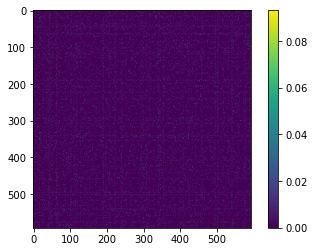

In [48]:
import matplotlib.pyplot as plt

X = nback_p_t
Xf = X.reshape(X.shape[0],-1)
e = cosineSimilarity(Xf,Xf)

def topK(e, k):
    n = e.shape[0]
    res = torch.zeros(e.shape).float().cuda()
    v,i = torch.topk(e,k,dim=0)
    res.scatter_(0,i,1)
    return (res+res.T)/2

e = normalize(topK(e,20)-torch.eye(e.shape[0]).float().cuda())
# print(torch.sum(e, dim=1))
# print(e[0])

plt.imshow(e.detach().cpu().numpy())
plt.colorbar()
plt.show()

In [50]:
ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()
nEpochs = 15000
pPeriod = 100
thresh = torch.Tensor((80,2e-1,40)).float().cuda()

nPoly = 1
para = [makePoly(nback_p_t), makePoly(emoid_p_t)]
    
rmse = []

for i in range(10):
    gcn = GCN(40, len(para), nPoly, 3, 0.5)
    optim = torch.optim.Adam(gcn.parameters(), lr=2e-5, weight_decay=2e-5)

    trainIdcs = groups[i][0]
    testIdcs = groups[i][1]
    
    X = torch.stack(para, dim=1)
    X = X[trainIdcs]
    Y = torch.from_numpy(X_all[trainIdcs]).float().cuda()
    
    gen = Y[:,1:]
    wrt = wrat_t[trainIdcs].unsqueeze(1)
    age = Y[:,0].unsqueeze(1)
    
    Xf = X.reshape(X.shape[0],-1)
    e = cosineSimilarity(Xf,Xf)
    e = normalize(topK(e,60)-torch.eye(e.shape[0]).float().cuda())
    
    for epoch in range(nEpochs):
        optim.zero_grad()
        res = gcn(X, age=age, gender=gen, wrat=wrt, e=e)
        loss0 = mseLoss(res[0], age)
        loss1 = ceLoss(res[1], gen)
        loss2 = mseLoss(res[2], wrt)
        loss = torch.stack([loss0, loss1, loss2])
        torch.sum(loss).backward()
        optim.step()
        if (epoch % pPeriod == 0 or epoch == nEpochs-1):
            print(f'epoch {epoch} loss={(float(loss0), float(loss1), float(loss2))}')
        if torch.all(loss < thresh):
            print('Early stopping')
            break
            
    print('Finished training')
    
    gcn.eval()
    
    X = torch.stack(para, dim=1)
    Y = torch.from_numpy(X_all).float().cuda()
    
    Xf = X.reshape(X.shape[0],-1)
    e = cosineSimilarity(Xf,Xf)
    e = normalize(topK(e,60)-torch.eye(e.shape[0]).float().cuda())
        
    gen = Y[:,1:]
    wrt = wrat_t.unsqueeze(1)
    age = Y[:,0].unsqueeze(1)

    gen0 = gen.clone().detach()
    gen0[testIdcs] = 0
    wrt0 = wrt.clone().detach()
    wrt0[testIdcs] = 0
    age0 = age.clone().detach()
    age0[testIdcs] = 0
    
    res = gcn(X, age=age0, gender=gen0, wrat=wrt0, e=e)
    loss0 = mseLoss(res[0][testIdcs].detach(), age[testIdcs]).cpu().numpy()**0.5
    frac1 = torch.sum(torch.argmax(res[1].detach(), dim=1)[testIdcs] 
                     == torch.argmax(gen[testIdcs], dim=1))/testIdcs.shape[0]
    loss2 = mseLoss(res[2][testIdcs].detach(), wrt[testIdcs]).cpu().numpy()**0.5
    
    rmse.append((float(loss0), float(frac1), float(loss2)))
    print(i, end=' ')
    print(rmse[-1])

epoch 0 loss=(34459.0859375, 0.7024935483932495, 10795.384765625)
epoch 100 loss=(8769.369140625, 27.839679718017578, 1624.3065185546875)
epoch 200 loss=(6848.20654296875, 25.55518341064453, 1466.6385498046875)
epoch 300 loss=(6572.83935546875, 17.42626953125, 1427.399169921875)
epoch 400 loss=(6279.41796875, 9.414765357971191, 1378.5645751953125)
epoch 500 loss=(5966.8056640625, 2.7518272399902344, 1321.9241943359375)
epoch 600 loss=(5634.30859375, 2.1160621643066406, 1257.0614013671875)
epoch 700 loss=(5292.9814453125, 2.0858936309814453, 1185.9716796875)
epoch 800 loss=(4943.76416015625, 2.053928852081299, 1112.6156005859375)
epoch 900 loss=(4582.375, 1.9975008964538574, 1035.29736328125)
epoch 1000 loss=(4229.9033203125, 1.9434707164764404, 957.1726684570312)
epoch 1100 loss=(3878.6943359375, 1.8597668409347534, 877.396484375)
epoch 1200 loss=(3545.1923828125, 1.7917605638504028, 802.3103637695312)
epoch 1300 loss=(3218.490234375, 1.7310447692871094, 726.88720703125)
epoch 1400 los

epoch 11000 loss=(46.329437255859375, 0.4586990177631378, 16.298246383666992)
epoch 11100 loss=(44.80678176879883, 0.4534294009208679, 14.655367851257324)
epoch 11200 loss=(55.44753646850586, 0.44425085186958313, 13.896390914916992)
epoch 11300 loss=(44.61590576171875, 0.4571024775505066, 14.818839073181152)
epoch 11400 loss=(48.175559997558594, 0.43555623292922974, 12.391796112060547)
epoch 11500 loss=(47.74247741699219, 0.4521143436431885, 14.276399612426758)
epoch 11600 loss=(49.21746063232422, 0.4322778284549713, 13.44290542602539)
epoch 11700 loss=(46.848236083984375, 0.4340870976448059, 12.833806037902832)
epoch 11800 loss=(46.176692962646484, 0.43092796206474304, 13.04074478149414)
epoch 11900 loss=(46.96719741821289, 0.42898130416870117, 13.52362060546875)
epoch 12000 loss=(47.5615234375, 0.415243536233902, 15.381288528442383)
epoch 12100 loss=(41.19466781616211, 0.4155370891094208, 11.675335884094238)
epoch 12200 loss=(41.25590515136719, 0.4147360026836395, 12.927358627319336)

epoch 6800 loss=(621.781494140625, 0.6903322339057922, 134.31361389160156)
epoch 6900 loss=(594.3854370117188, 0.6764118671417236, 130.42709350585938)
epoch 7000 loss=(584.3712768554688, 0.6689168214797974, 127.01651763916016)
epoch 7100 loss=(569.5313720703125, 0.6624698638916016, 119.1265869140625)
epoch 7200 loss=(558.3237915039062, 0.6541301012039185, 119.75603485107422)
epoch 7300 loss=(549.7372436523438, 0.6509072780609131, 115.53233337402344)
epoch 7400 loss=(532.8190307617188, 0.643216073513031, 112.64566040039062)
epoch 7500 loss=(511.6120300292969, 0.6402819156646729, 109.2720718383789)
epoch 7600 loss=(497.8311462402344, 0.6280880570411682, 106.57825469970703)
epoch 7700 loss=(477.1590576171875, 0.6265625953674316, 102.51295471191406)
epoch 7800 loss=(476.1618347167969, 0.6263110041618347, 97.16010284423828)
epoch 7900 loss=(448.7970275878906, 0.6158521771430969, 92.94811248779297)
epoch 8000 loss=(438.19525146484375, 0.6142286658287048, 89.67803192138672)
epoch 8100 loss=(4

epoch 2500 loss=(970.8186645507812, 0.8338453769683838, 230.32952880859375)
epoch 2600 loss=(942.4384765625, 0.8393099904060364, 224.9134979248047)
epoch 2700 loss=(907.3616333007812, 0.8383030295372009, 218.0338592529297)
epoch 2800 loss=(884.5516967773438, 0.8358588218688965, 217.65460205078125)
epoch 2900 loss=(862.1246948242188, 0.8398704528808594, 211.53564453125)
epoch 3000 loss=(839.1370849609375, 0.8441470265388489, 208.15032958984375)
epoch 3100 loss=(812.2188110351562, 0.8395175337791443, 204.60324096679688)
epoch 3200 loss=(795.0886840820312, 0.8382911682128906, 197.66131591796875)
epoch 3300 loss=(754.5082397460938, 0.8311614394187927, 197.65281677246094)
epoch 3400 loss=(743.6922607421875, 0.8335433602333069, 189.7532196044922)
epoch 3500 loss=(712.8645629882812, 0.8251714706420898, 185.85255432128906)
epoch 3600 loss=(686.9619750976562, 0.8223800659179688, 184.4989776611328)
epoch 3700 loss=(670.4132690429688, 0.8008436560630798, 181.42556762695312)
epoch 3800 loss=(640.7

KeyboardInterrupt: 